In [1]:
from auditor import *

### User defined inputs ###

In [2]:
# Identify filenames for control, treatment and demographic information

control_ = "HRo1" #Raw text resume input
control_file = './Personality Prediction AI/data/'+control_+'.csv'

treatment_dict = { 
                'HRi1': 'De-Identified Resume', 
                'HRi2': 'De-Identified Resume', 
                'HRi3': 'De-Identified REsume', 
                'HRd1': 'DOCX Resume', 
                'HRu1': 'URL-Embedded Resume', 
                'HL1': 'LinkedIn', 
                'HL2': 'LinkedIn', 
                'HT1': 'Twitter', 
                'HT2': 'Twitter'}

demographic_data_filename = "./Personality Prediction AI/data/survey.csv"

#Demographic information of interest:
groups_of_interest = {"gender": ["Female"], "race": ["White", "Asian"], "birth_country": ["India", "USA"]}


# Define the score_names (target labels) and the primary key between control, treatments and demographic information
score_names = ['Openness', 'Big Five Conscientiousness', 'Extraversion', 'Agreeableness', 'Emotional Stability']
primary_key = 'Participant_ID'

### Load the data: control and treatment inputs ###

In [3]:
control_input_df = pd.read_csv(control_file, index_col=primary_key)
control_input_df.head()

,Dominance,Influence,Steadiness,DiSC Calculativeness,Openness,Big Five Conscientiousness,Extraversion,Agreeableness,Emotional Stability,Attitude and Outlook,Need for Autonomy,Teamwork Skills,General Behavior,Action Orientedness,Stability Potential,Learning Ability,Confidence Score,output_success
Participant_ID,,,,,,,,,,,,,,,,,,
ID49,7.4,4.7,3.3,6.7,6.06,5.67,2.78,4.89,6.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,False
ID2,3.1,4.3,9.3,9.2,5.71,7.22,5.32,7.25,6.35,6.8,6.9,6.2,7.5,5.4,6.2,6.0,100.0,True
ID3,6.4,5.1,6.0,8.3,5.93,5.82,4.01,5.43,5.94,5.3,5.7,5.2,5.8,4.4,8.3,4.9,59.1,True
ID4,6.6,5.4,5.2,6.6,6.17,6.51,5.35,6.63,4.03,4.7,5.0,4.5,4.5,6.2,6.0,6.5,100.0,True
ID5,6.1,4.7,4.9,7.8,5.80,5.07,5.89,5.25,5.01,5.1,5.1,4.4,4.9,5.0,6.4,6.7,100.0,True


In [4]:
treatment_input = {}
for treatment_ in treatment_dict.keys():
    treatment_file = './Personality Prediction AI/data/'+treatment_+'.csv'
    treatment_input[treatment_dict[treatment_]] = pd.read_csv(treatment_file, index_col=primary_key)

### Load demographic data ###

In [5]:
demographic_df = pd.read_csv(demographic_data_filename, index_col=primary_key)

In [6]:
demographic_df.head()

,gender,race,birth_country,primary_language,resume,linkedin,twitter,linkedin_in_orig_resume,orig_embed_type,orig_file_type
Participant_ID,,,,,,,,,,
ID2,Male,Asian,USA,English,True,True,False,True,Full url hyperlinked,pdf
ID3,Male,Asian,USA,English,True,True,False,False,NaN,pdf
ID4,Male,Asian,India,Other Language,True,True,True,False,NaN,pdf
ID5,Male,White,Other Country,English,True,True,False,True,Full url hyperlinked,docx
ID6,Male,White,USA,English,True,True,False,True,Full url hyperlinked,pdf


### Only retaining IDs that exist in the control and all treatments

In [7]:
# We cannot compare scores if IDs are missing across treatments

ID_ = []

for treatment in treatment_input.keys():
    ID_.append(set(set.intersection(set(control_input_df.index), set(treatment_input[treatment].index))))
    
ID_list = list(set.intersection(*ID_))

In [8]:
demographic_df = demographic_df.loc[ID_list]
control_input_df = control_input_df.loc[ID_list]

for treatment in treatment_input.keys():
    treatment_input[treatment] = treatment_input[treatment].loc[ID_list]

### Hit the ADS to get scores for control and treatments ###

In [9]:
ADS_blackbox = ADS(score_names, primary_key)

This is an example of an external audit -- we only have blackbox access to the ADS, so the score function we will use here is a simple look-up. The "feature" X here is simply the primary ID that identifies a record

In [10]:
control_scores = ADS_blackbox.score(X=ID_list, score_func=functools.partial(ADS_lookup, filename=control_file))
control_scores.head()

,Openness,Big Five Conscientiousness,Extraversion,Agreeableness,Emotional Stability
Participant_ID,,,,,
ID45,4.96,6.58,7.03,6.33,5.34
ID35,6.09,6.75,3.88,6.61,6.98
ID4,6.17,6.51,5.35,6.63,4.03
ID68,5.05,7.26,4.54,5.69,5.06
ID29,6.18,4.54,5.75,5.57,4.70


In [11]:
treatment_scores = {}
for treatment_ in treatment_dict.keys():
    treatment_file = './Personality Prediction AI/data/'+treatment_+'.csv'
    treatment_scores[treatment_dict[treatment_]] = ADS_blackbox.score(X=ID_list, score_func=functools.partial(ADS_lookup, filename=treatment_file))

## Auditing the stability of the scores for different treatments ##

### Instantiate the Auditor class ###

In [12]:
stability_audit = Auditor(score_names, primary_key, control_scores, 
                          treatment_scores, demographic_df, groups_of_interest)

### Visualizing scores for control and treatment 

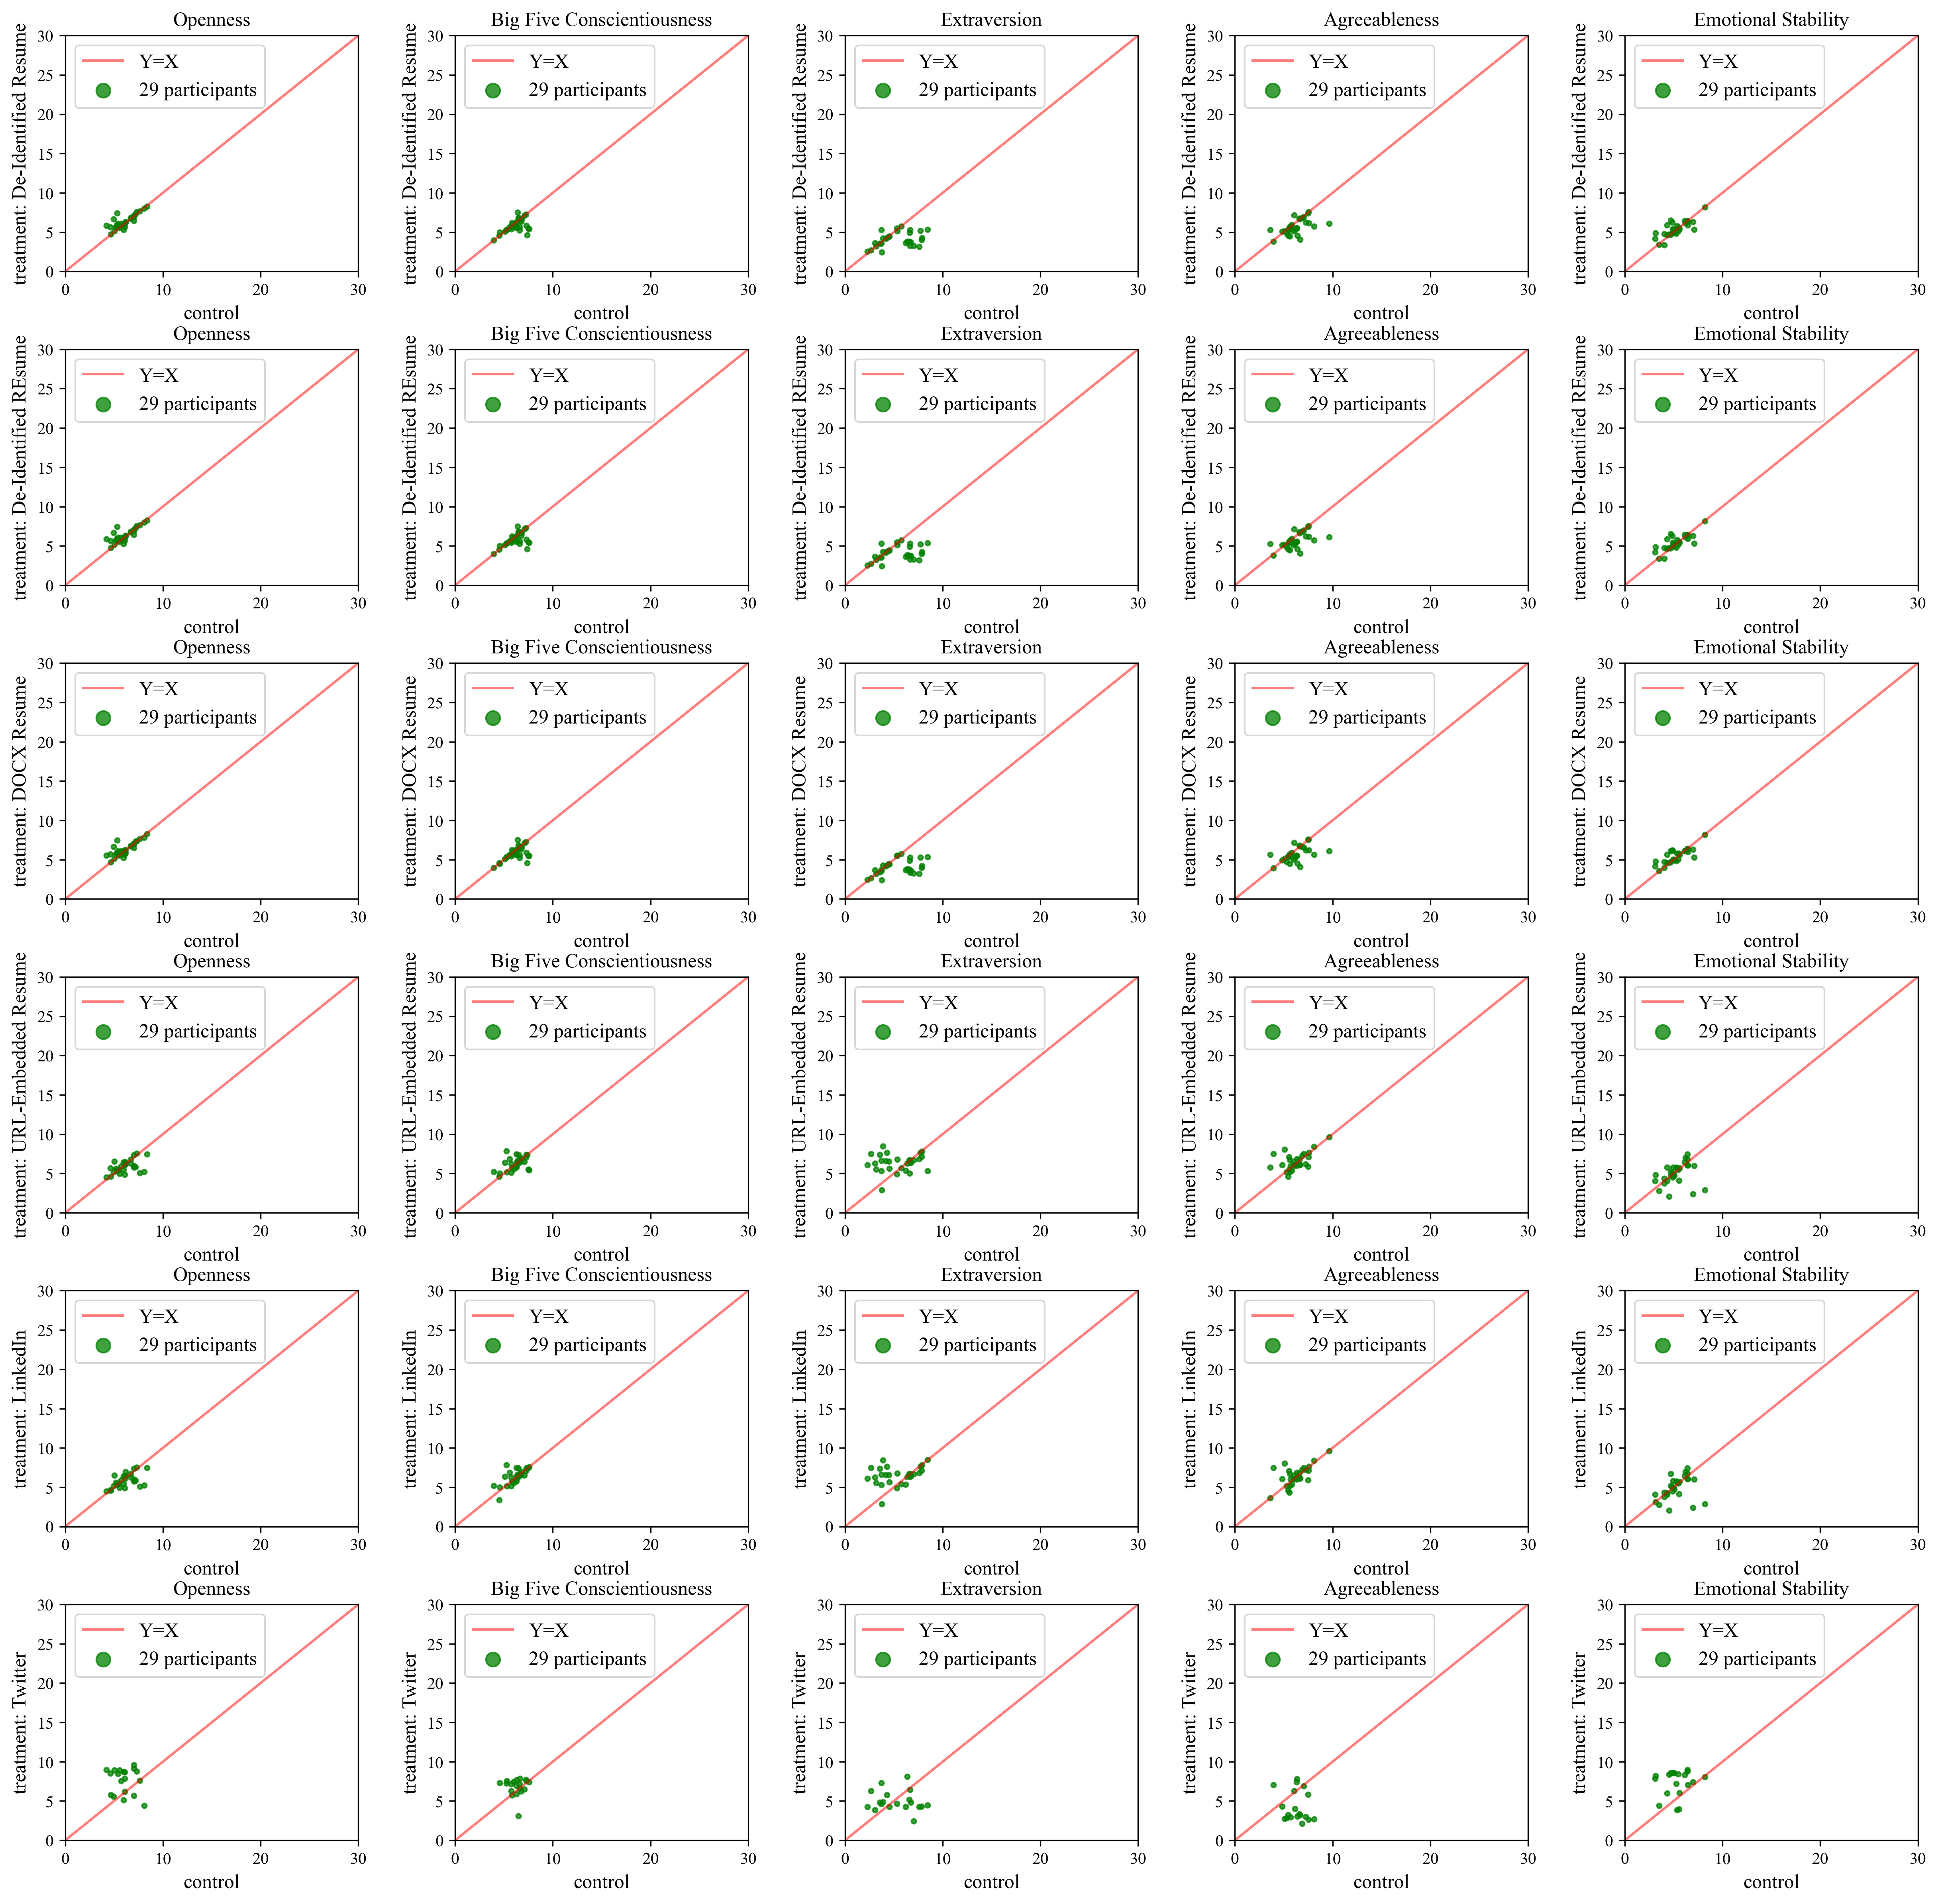

In [13]:
stability_audit.visualize_scores(axislim=30)

### Total change between control and treatment as a measure of stability ###

In [14]:
stability_audit.compute_total_variation()

Openness  \
De-Identified Resume overall__            mean  0.414138   
                                          std   0.556613   
                     gender_Female        mean  0.397778   
                                          std   0.682693   
                     gender_others        mean  0.421500   
...                                                  ...   
Twitter              birth_country_India  std   1.626507   
                     birth_country_USA    mean  2.801250   
                                          std   0.826740   
                     birth_country_others mean  2.592500   
                                          std   1.029348   

                                                Big Five Conscientiousness  \
De-Identified Resume overall__            mean                    0.555172   
                                          std                     0.741551   
                     gender_Female        mean                    0.597778   
                                          std                     0.853841   
                     gender_others        mean                    0.536000   
...                                                                    ...   
Twitter              birth_country_India  std                     0.971729   
                     birth_country_USA    mean                    1.406250   
                                          std                     1.088169   
                     birth_country_others mean                    0.817500   
                                          std                     0.552532   

                                                Extraversion  Agreeableness  \
De-Identified Resume overall__            mean      1.500690       0.777241   
                                          std       1.503263       0.903600   
                     gender_Female        mean      1.146667       0.640000   
                                          std       1.230864       0.660511   
                     gender_others        mean      1.660000       0.839000   
...                                                      ...            ...   
Twitter              birth_country_India  std       1.516052       1.852131   
                     birth_country_USA    mean      1.790000       3.055000   
                                          std       1.235742       0.875345   
                     birth_country_others mean      2.580000       3.495000   
                                          std       1.515718       1.344780   

                                                Emotional Stability  
De-Identified Resume overall__            mean             0.535862  
                                          std              0.587474  
                     gender_Female        mean             0.425556  
                                          std              0.434514  
                     gender_others        mean             0.585500  
...                                                             ...  
Twitter              birth_country_India  std              1.220934  
                     birth_country_USA    mean             2.673750  
                                          std              1.373972  
                     birth_country_others mean             2.960000  
                                          std              1.961479  

[108 rows x 5 columns]

### Visualizing the total change (L1 norm)

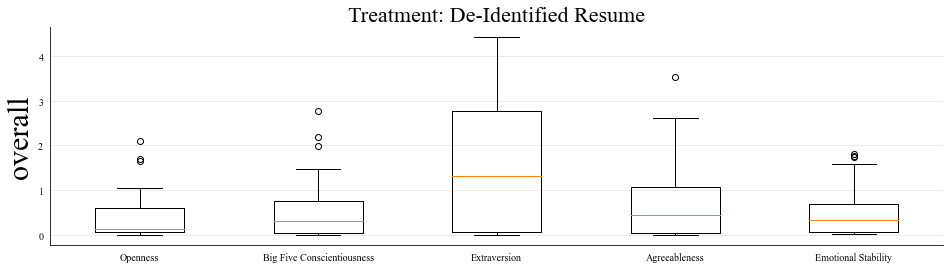

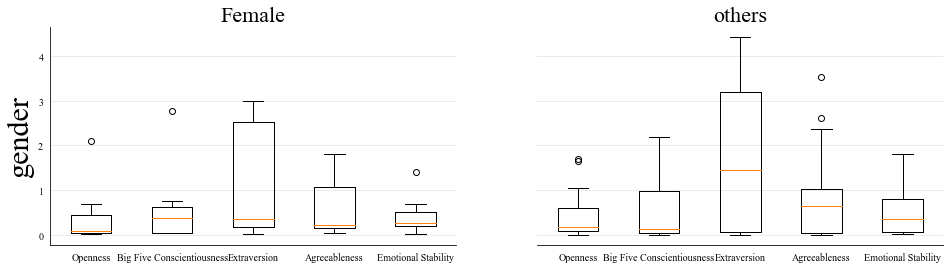

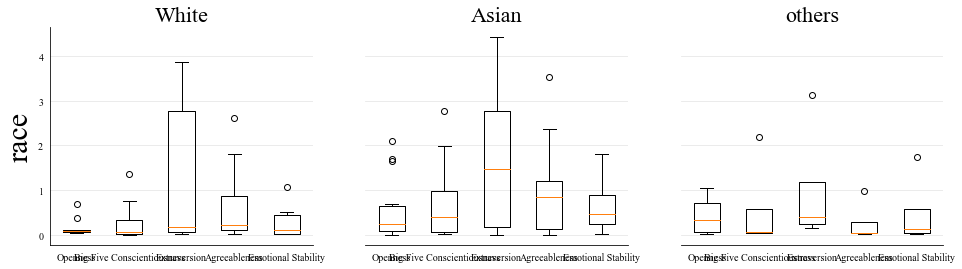

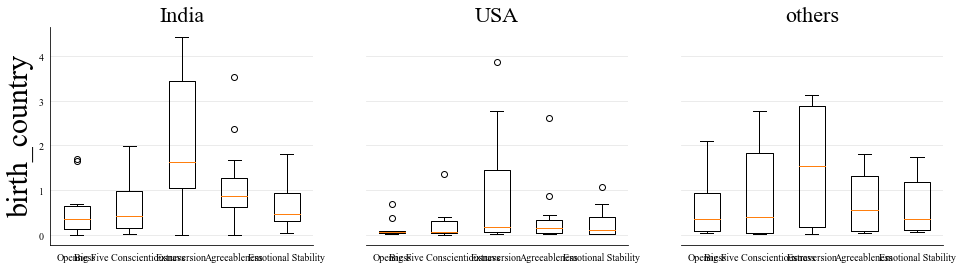

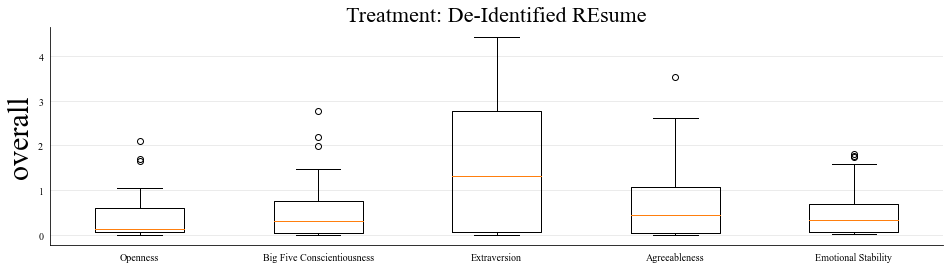

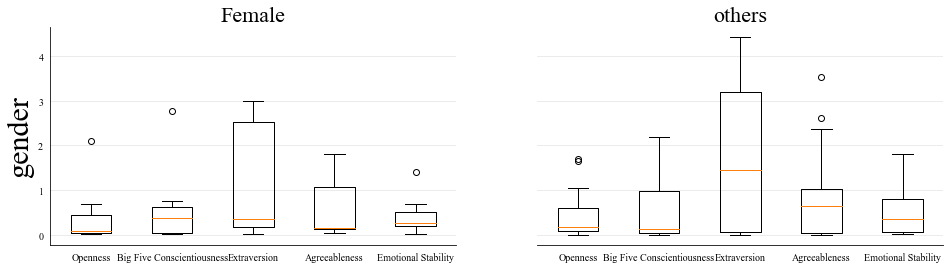

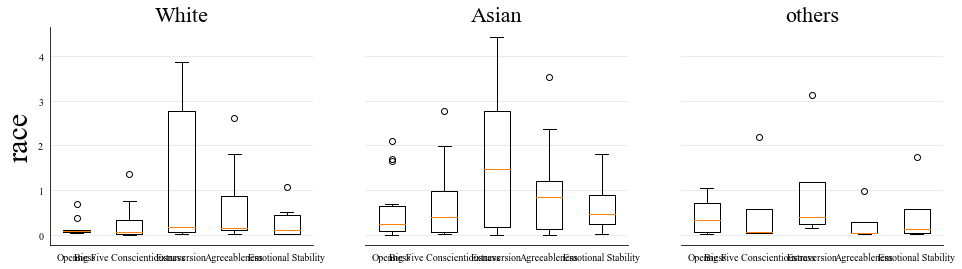

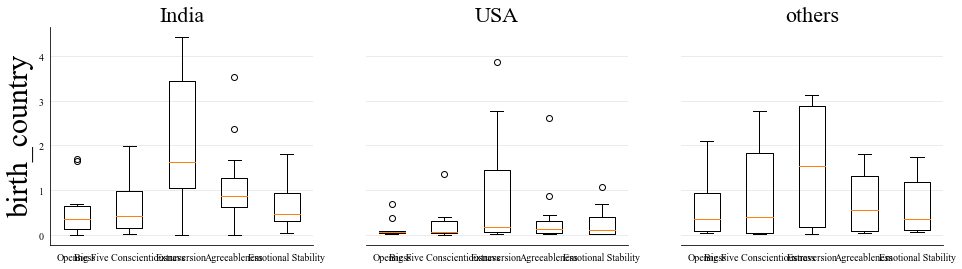

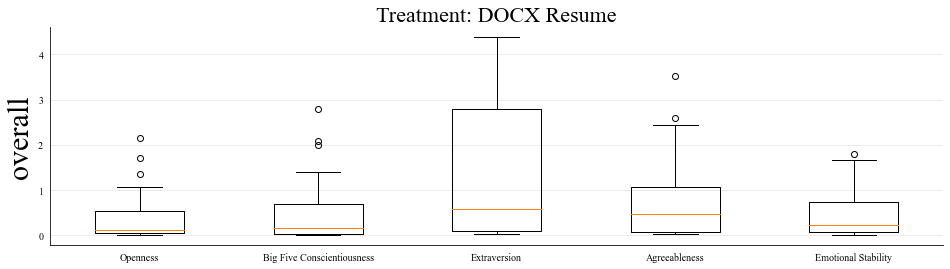

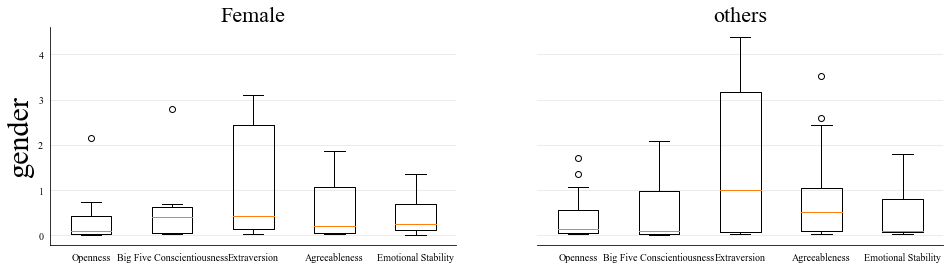

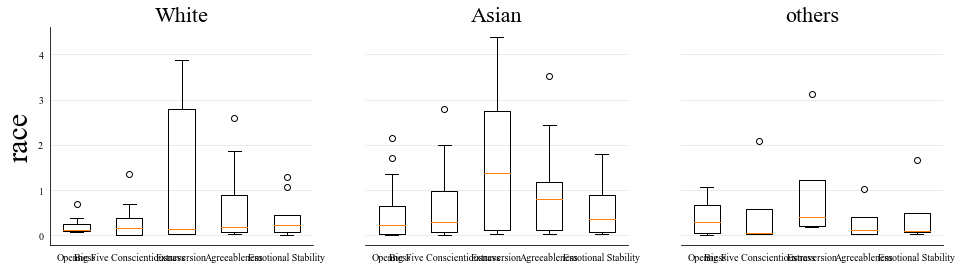

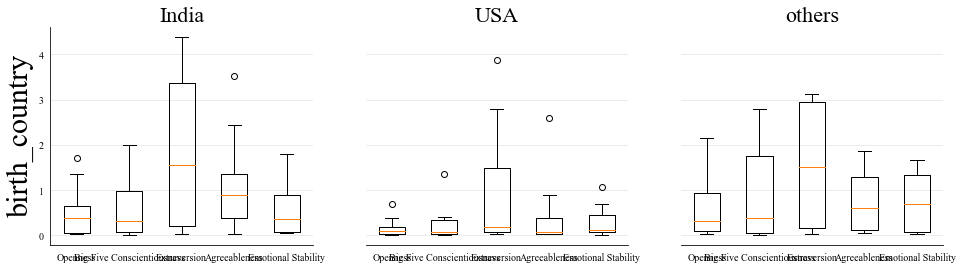

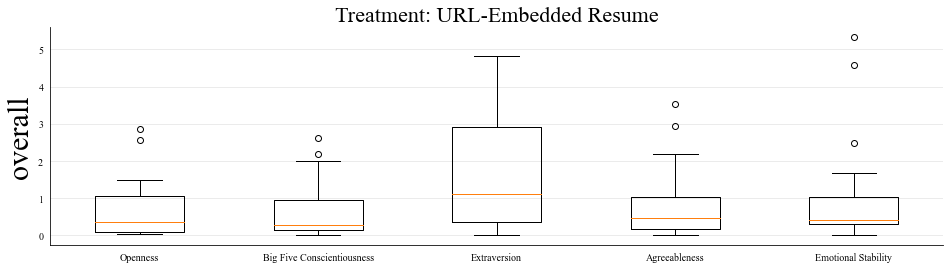

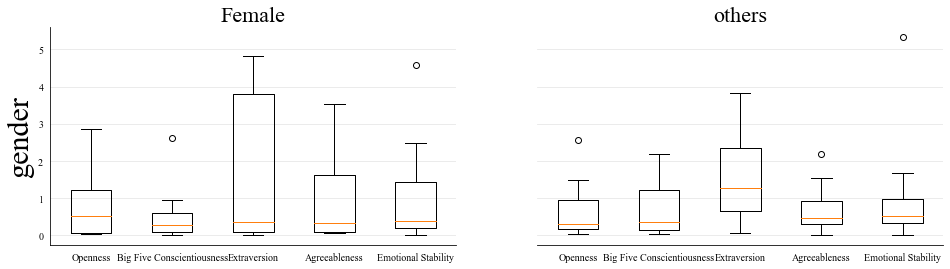

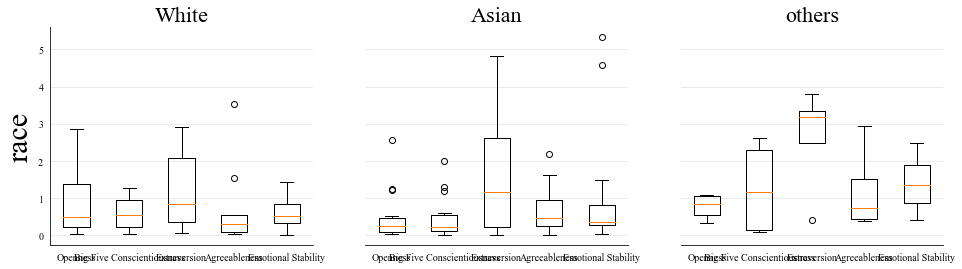

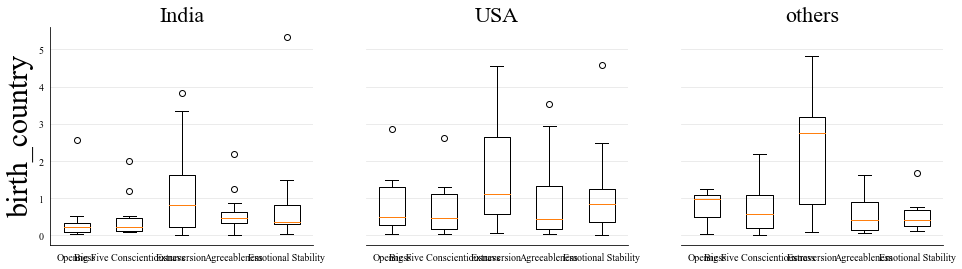

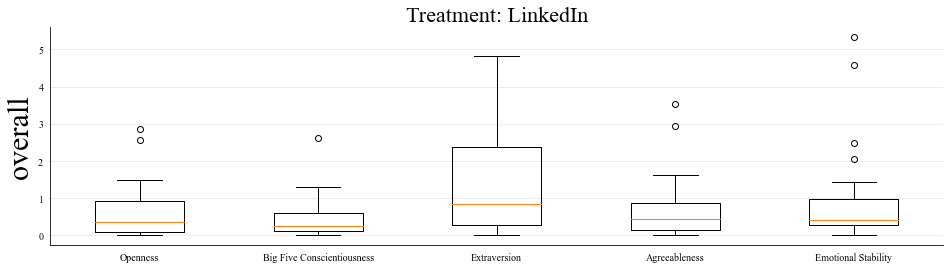

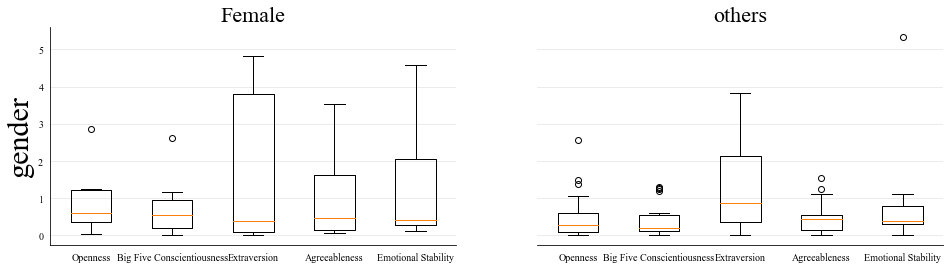

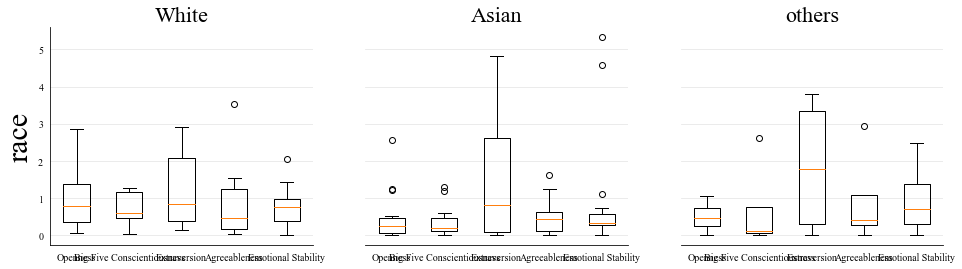

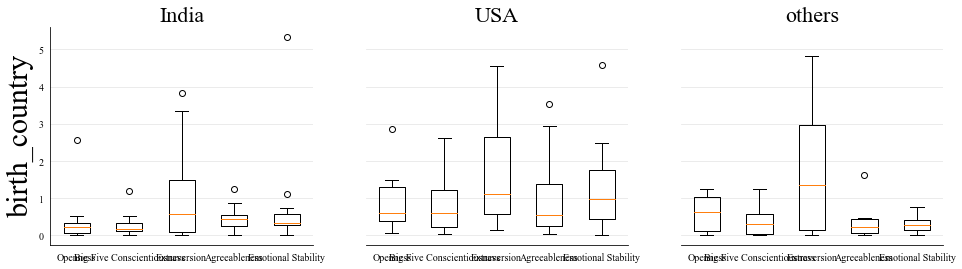

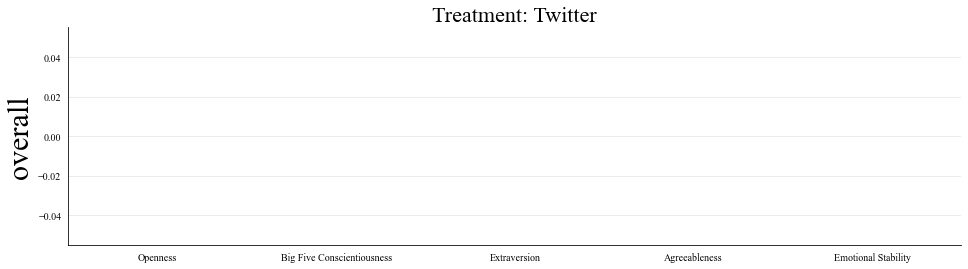

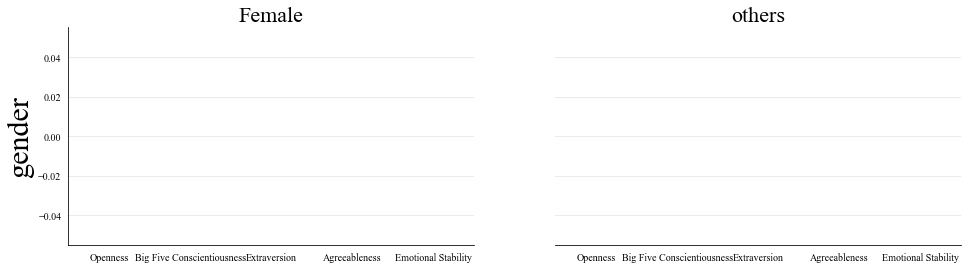

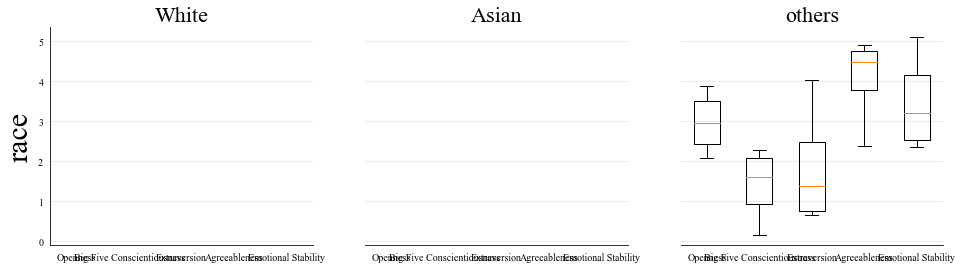

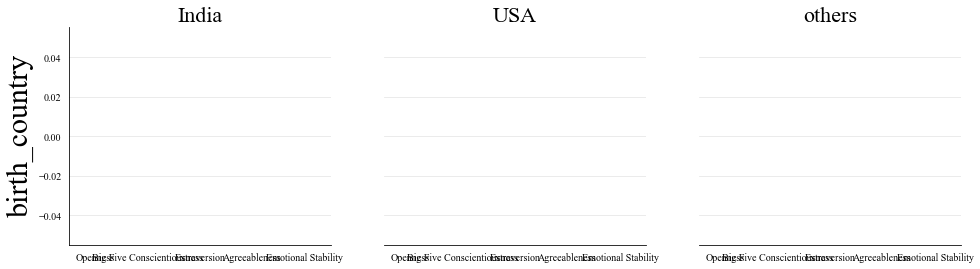

In [15]:
stability_audit.visualize_total_variation()

### Correlation between control and treatment as a measure of rank-order stability

In [16]:
spearman_ = stability_audit.compute_statistic(test=spearman)
spearman_

Openness  \
De-Identified Resume overall__            correlation  0.753388   
                                          p_value      0.000002   
                     gender_Female        correlation  0.450000   
                                          p_value      0.224216   
                     gender_others        correlation  0.875517   
...                                                         ...   
Twitter              birth_country_India  p_value           NaN   
                     birth_country_USA    correlation       NaN   
                                          p_value           NaN   
                     birth_country_others correlation       NaN   
                                          p_value           NaN   

                                                       Big Five Conscientiousness  \
De-Identified Resume overall__            correlation                    0.457995   
                                          p_value                        0.012476   
                     gender_Female        correlation                    0.450000   
                                          p_value                        0.224216   
                     gender_others        correlation                    0.480632   
...                                                                           ...   
Twitter              birth_country_India  p_value                             NaN   
                     birth_country_USA    correlation                         NaN   
                                          p_value                             NaN   
                     birth_country_others correlation                         NaN   
                                          p_value                             NaN   

                                                       Extraversion  \
De-Identified Resume overall__            correlation      0.343723   
                                          p_value          0.067901   
                     gender_Female        correlation      0.650000   
                                          p_value          0.058073   
                     gender_others        correlation      0.130926   
...                                                             ...   
Twitter              birth_country_India  p_value               NaN   
                     birth_country_USA    correlation           NaN   
                                          p_value               NaN   
                     birth_country_others correlation           NaN   
                                          p_value               NaN   

                                                       Agreeableness  \
De-Identified Resume overall__            correlation       0.648436   
                                          p_value           0.000142   
                     gender_Female        correlation       0.633333   
                                          p_value           0.067086   
                     gender_others        correlation       0.653629   
...                                                              ...   
Twitter              birth_country_India  p_value                NaN   
                     birth_country_USA    correlation            NaN   
                                          p_value                NaN   
                     birth_country_others correlation            NaN   
                                          p_value                NaN   

                                                       Emotional Stability  
De-Identified Resume overall__            correlation             0.703462  
                                          p_value                 0.000021  
                     gender_Female        correlation             0.786618  
                                          p_value                 0.011909  
                     gender_others        correlation             0.713050  
...                                              

In [17]:
# User defined threshold
corr_threshold = 0.9

In [18]:
# If correlation is greater than the threshold, ADS is stable for that treatment
spearman_.loc[[i for i in spearman_.index if 'correlation' in i]] >= corr_threshold

Openness  \
De-Identified Resume overall__            correlation     False   
                     gender_Female        correlation     False   
                     gender_others        correlation     False   
                     race_White           correlation     False   
                     race_Asian           correlation     False   
                     race_others          correlation     False   
                     birth_country_India  correlation     False   
                     birth_country_USA    correlation      True   
                     birth_country_others correlation     False   
De-Identified REsume overall__            correlation     False   
                     gender_Female        correlation     False   
                     gender_others        correlation     False   
                     race_White           correlation     False   
                     race_Asian           correlation     False   
                     race_others          correlation     False   
                     birth_country_India  correlation     False   
                     birth_country_USA    correlation      True   
                     birth_country_others correlation     False   
DOCX Resume          overall__            correlation     False   
                     gender_Female        correlation     False   
                     gender_others        correlation     False   
                     race_White           correlation      True   
                     race_Asian           correlation     False   
                     race_others          correlation     False   
                     birth_country_India  correlation     False   
                     birth_country_USA    correlation      True   
                     birth_country_others correlation     False   
URL-Embedded Resume  overall__            correlation     False   
                     gender_Female        correlation     False   
                     gender_others        correlation     False   
                     race_White           correlation     False   
                     race_Asian           correlation     False   
                     race_others          correlation     False   
                     birth_country_India  correlation     False   
                     birth_country_USA    correlation     False   
                     birth_country_others correlation     False   
LinkedIn             overall__            correlation     False   
                     gender_Female        correlation     False   
                     gender_others        correlation     False   
                     race_White           correlation     False   
                     race_Asian           correlation     False   
                     race_others          correlation      True   
                     birth_country_India  correlation     False   
                     birth_country_USA    correlation     False   
                     birth_country_others correlation     False   
Twitter              overall__            correlation     False   
                     gender_Female        correlation     False   
                     gender_others        correlation     False   
                     race_White           correlation     False   
                     race_Asian           correlation     False   
                     race_others          correlation      True   
                     birth_country_India  correlation     False   
                     birth_country_USA    correlation     False   
                     birth_country_others correlation     False   

                                                       Big Five Conscientiousness  \
De-Identified Resume overall__            correlation                       False   
                     gender_Female        correlation                       False   
                     gender_others        correlation                       False   
                     race_Whi

### Wilcoxon signed rank test as a measure of locational stability

In [19]:
wilcoxon_ = stability_audit.compute_statistic(test=wilcoxon)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


### Correcting for multiple hypothesis testing 

In [20]:
pvals = wilcoxon_.loc[[i for i in wilcoxon_.index if 'p_value' in i]]

In [21]:
# User defined threshold
alpha_threshold = 0.05

In [22]:
# Using Benjamini-Hochberg correction here
corrected = stability_audit.multiple_hypothesis_correction(pvals, alpha = alpha_threshold, method='fdr_bh')

In [23]:
# Null hypothesis is that both samples are from the same distribution
# P_value less than threshold rejects the null hypothesis
# Hence, p_Value larger than threshold means that the ADS is stable for that treatment

corrected[stability_audit.score_names] > alpha_threshold

Openness  \
De-Identified Resume overall__            p_value      True   
                     gender_Female        p_value      True   
                     gender_others        p_value      True   
                     race_White           p_value      True   
                     race_Asian           p_value      True   
                     race_others          p_value      True   
                     birth_country_India  p_value      True   
                     birth_country_USA    p_value      True   
                     birth_country_others p_value      True   
De-Identified REsume overall__            p_value      True   
                     gender_Female        p_value      True   
                     gender_others        p_value      True   
                     race_White           p_value      True   
                     race_Asian           p_value      True   
                     race_others          p_value      True   
                     birth_country_India  p_value      True   
                     birth_country_USA    p_value      True   
                     birth_country_others p_value      True   
DOCX Resume          overall__            p_value      True   
                     gender_Female        p_value      True   
                     gender_others        p_value      True   
                     race_White           p_value      True   
                     race_Asian           p_value      True   
                     race_others          p_value      True   
                     birth_country_India  p_value      True   
                     birth_country_USA    p_value      True   
                     birth_country_others p_value      True   
URL-Embedded Resume  overall__            p_value      True   
                     gender_Female        p_value      True   
                     gender_others        p_value      True   
                     race_White           p_value      True   
                     race_Asian           p_value      True   
                     race_others          p_value      True   
                     birth_country_India  p_value      True   
                     birth_country_USA    p_value      True   
                     birth_country_others p_value      True   
LinkedIn             overall__            p_value      True   
                     gender_Female        p_value      True   
                     gender_others        p_value      True   
                     race_White           p_value      True   
                     race_Asian           p_value      True   
                     race_others          p_value      True   
                     birth_country_India  p_value      True   
                     birth_country_USA    p_value      True   
                     birth_country_others p_value      True   
Twitter              overall__            p_value     False   
                     gender_Female        p_value      True   
                     gender_others        p_value     False   
                     race_White           p_value      True   
                     race_Asian           p_value     False   
                     race_others          p_value      True   
                     birth_country_India  p_value      True   
                     birth_country_USA    p_value      True   
                     birth_country_others p_value      True   

                                                   Big Five Conscientiousness  \
De-Identified Resume overall__            p_value                        True   
                     gender_Female        p_value                        True   
                     gender_others        p_value                        True   
                     race_White           p_value                        True   
                     race_Asian           p_value                        True   
                     race_others          p_value                        True   
                  